In [6]:
# Import packages

from scipy.interpolate import interp1d
import time
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
get_ipython().run_line_magic('matplotlib', 'inline')
import datetime
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
import bisect
import copy
import json
import csv
import ast
import pylab as pl
import time
from scipy.special import erf
from scipy import integrate
from scipy.integrate import quad, dblquad
from scipy.integrate import simps


c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

ios_colors=[c5, c1, c3, c7, c2, c6, c4, c9, c8]

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

color_list=list(map(to_rgb_frac, [(166,206,227),(178,223,138),(51,160,44),(31,120,180)]))

# Lists of colors for plots

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

rb_div_5=list(map(to_rgb_frac, [(202,0,32),
(244,165,130),
(247,247,247),
(146,197,222),
(5,113,176)]))

qualitative_10=list(map(to_rgb_frac, [(166,206,227),
(31,120,180),
(178,223,138),
(51,160,44),
(251,154,153),
(227,26,28),
(253,191,111),
(255,127,0),
(202,178,214),
(106,61,154)]))


In [8]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [9]:
datafile='Loss_of_Y.csv'
trimmed_fmin=0.00001 # trimming data below with negative LOY
trimmed_fmin=5/100
trimmed_fmax=1

list_of_LOY=[]

with open(datafile) as data:
    reader = csv.reader(data,delimiter=',')
    next(reader, None)   #skips header
    
    for row in reader:
        sample_ID=str(row[0])
        LOY=float(row[4])/100
        
        if trimmed_fmin < LOY < trimmed_fmax:
            list_of_LOY.append(LOY)
            

n_sample = 121
        
print('There are', len(list_of_LOY), 'many samples collected at 93-year old with non-negative LOY out of 121 samples.')

There are 94 many samples collected at 93-year old with non-negative LOY out of 121 samples.


# Plotting functions

In [10]:
scale = 1.2
def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
#         print('normalised_hist is of type', type(normalised_hist))
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

# for plotting nonsynonymous VAF
def plot_log_hist_data_for_plot_rescaled(study_VAFs, study_total, u_nonsyn, n_bins, lmin, lmax, study_name, marker_name, marker_size, color):
    
    # study_VAFs is a list of strings
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = study_total*2*u_nonsyn
    hist, bins = np.histogram(log_VAFs, bins=n_bins, range=(lmin, lmax))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
 

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
    print('hist without zero is', hist_without_zero)
    width_scalar=widths[0]
    normalised_hist = hist_without_zero/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist_without_zero, normed_value, widths)
    
#     scale=1.2
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2
    
    ax1.errorbar(bin_centres_without_zero, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=layer)
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    ax1.set_ylim(min(log_hist_for_plot), max(log_hist_for_plot))


    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks =  [np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
              
    x_major_tick_labels =  [ "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]

    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

    y_major_ticks = [np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_ticks = [c-np.log(10**4) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{-2}$","", "", "", "", "", "", "", "", "$10^{-1}$","", "", "", "", "", "", "", "", \
                           "$10^{0}$","", "", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", "$10^{2}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1

def plot_log_hist_data_for_plot_not_rescaled(study_VAFs, study_total, n_bins, lmin, lmax, study_name, marker_name, marker_size, color):
    # study_VAFs is a list of strings
    
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = study_total
    hist, bins = np.histogram(log_VAFs, bins=n_bins, range=(lmin, lmax))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
 

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
    print('hist without zero is', hist_without_zero)
    width_scalar=widths[0]
    normalised_hist = hist_without_zero/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist_without_zero, normed_value, widths)
    
#     scale=1.2
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(bin_centres_without_zero, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=3)
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    ax1.set_ylim(min(log_hist_for_plot), max(log_hist_for_plot))
    ax1.set_xlim(np.log(10**-3), 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks =  [np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
                 
    x_major_tick_labels =  [ "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","","100"]
                         
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

    y_major_ticks = [np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_ticks = [c-np.log(10**4) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{-2}$","", "", "", "", "", "", "", "", "$10^{-1}$","", "", "", "", "", "", "", "", \
                           "$10^{0}$","", "", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", "$10^{2}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1

# Define theoretical predictions 

In [12]:
N_tau=10**5
# Y_loss_cohort = 121
c=1

# u_LOY is the mutation rate per cell per year
def Predicted_LOY_drift_with_cutoff(l, N_tau, u_LOY, t):
    return N_tau*u_LOY*np.exp(-N_tau/(c*t)*(np.exp(l)/(1-np.exp(l))))

#  beneficial with cutoff
def Predicted_LOY_beneficial_with_cutoff(l, N_tau, u_LOY, t, s):
    return N_tau*u_LOY*(1 + np.exp(l)/(1-np.exp(l)))*np.exp(- N_tau*s/(np.exp(s*t)-1)*np.exp(l)/(1-np.exp(l))      )


u_LOY:  1.3e-06


# Optimisation of 3/2/1 parameters

In [33]:


def not_rescaled_VAF_densities_list(trimmed_VAF_list, study_total, n_bins, lmin, lmax):
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in trimmed_VAF_list:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = study_total
    hist, bins = np.histogram(log_VAFs, bins=np.linspace(lmin, lmax, n_bins))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
 

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
#     print('hist without zero is', hist_without_zero)
    width_scalar=widths[0]
    normalised_hist = hist_without_zero/(normed_value*width_scalar)
#     print('width_scalar', width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
#     print('normalised_hist is', normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist_without_zero, normed_value, widths)
    
    VAF_densities=[]
    lower_error = []
    upper_error = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
    VAF_densities_zip = zip(bin_centres_without_zero, log_hist_for_plot, lower_error, upper_error)
    for a, b, c, d in VAF_densities_zip:
        VAF_densities.append((a, b, c, d))
        
    return VAF_densities

def rescaled_VAF_densities_list(trimmed_VAF_list, study_total, u_syn, n_bins_syn, lmin, lmax):
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in trimmed_VAF_list:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = study_total*2*u_syn
    hist, bins = np.histogram(log_VAFs, bins=np.linspace(lmin, lmax, n_bins_syn))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
 

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
#     print('hist without zero is', hist_without_zero)
    width_scalar=widths[0]
    normalised_hist = hist_without_zero/(normed_value*width_scalar)
#     print('width_scalar', width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
#     print('normalised_hist is', normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist_without_zero, normed_value, widths)
    
    VAF_densities=[]
    lower_error = []
    upper_error = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
    VAF_densities_zip = zip(bin_centres_without_zero, log_hist_for_plot, lower_error, upper_error)
    for a, b, c, d in VAF_densities_zip:
        VAF_densities.append((a, b, c, d))
        
    return VAF_densities

def squared_distance_calculation_nonsyn_2D(params, N_tau, data, list_of_ages, lmin, lmax, n_bins): #d = data (number of variants within a given bin), lamb (lambda) = expected number of variants in the bin from theory
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    u_LOY = params[0]
    s = params[1]
#     N_tau = params[2]
    total_square_distance = 0
    
    bin_size=(lmax-lmin)/(n_bins-1)
    
    for datapoint in data:
        if True: 
            logfreq = datapoint[0] 
#             print('VAF is', np.exp(logfreq))
            data_density = datapoint[1]
#             print('data density is ', data_density)
            predicted_density = 0
            for j in range(len(list_of_ages)):
                t=list_of_ages[j]
                theory_binned=integrate.quad(lambda l: Predicted_LOY_beneficial_with_cutoff(l, N_tau, u_LOY, t, s)/bin_size,\
                                         logfreq-bin_size/2, logfreq+bin_size/2)[0]
                predicted_density=\
                predicted_density+(theory_binned/len(list_of_ages))
             

            predicted_log_density = np.log(predicted_density)
            square_distance = ((datapoint[1] - predicted_log_density)**2)  
#             print('square distance is', square_distance, 'at VAF', np.exp(datapoint[0]), \
#                   'where data is at', datapoint[1],'and predicted log density is at', predicted_log_density)
            upper_sigma_log = datapoint[3] 
            lower_sigma_log = datapoint[2] 
            sigma=(upper_sigma_log+lower_sigma_log)/2
            
            total_square_distance = total_square_distance + square_distance/sigma**2  # weighted by error
     
    return total_square_distance



In [34]:
# trim LOY data       
VAF_info_LOY = not_rescaled_VAF_densities_list(list_of_LOY, n_sample, n_bins_LOY, lmin_LOY, lmax_LOY)
# not rescaled because this is nonsynonymous VAF density

print('number of bins set:', n_bins_LOY)
print('number of nonempty bins:', len(VAF_info_LOY))


number of bins set: 11
number of nonempty bins: 10


In [38]:
# fit LOY with 2 parameters:  beneficial mut rate, s
import scipy

list_of_ages = [93]

u_LOY_guess=10**-5
s_guess=0.11

initial_guess=[u_LOY_guess, s_guess]
outcome=scipy.optimize.minimize(squared_distance_calculation_nonsyn_2D, initial_guess, \
                                args=(N_tau, VAF_info_LOY, list_of_ages, lmin_LOY, lmax_LOY, n_bins_LOY), method='Nelder-Mead', \
                                options={'maxfev':1000000, 'maxiter':1000000},\
                                )

# bounds=[(u_NOTCH1_min, u_NOTCH1_max),(s_guess_min,s_guess_max)]
print('Success of fitting outcome is', outcome.success)

print('best-fit values for u_NOTCH1, s:',  outcome.x)
s_LOY_bestfit = 1.09857028e-01
u_LOY_bestfit = 2.47713443e-06

Success of fitting outcome is True
best-fit values for u_NOTCH1, s: [2.47713443e-06 1.09857028e-01]


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in log


In [50]:
# functions for calculating confidence levels in 2-parameter fit
scale = 1.2

def confidence_interval_95_s(x1, y1, z1, gene_color): #95% confidence interval for s
    x1y1z1 = zip(x1, y1, z1)
    
    xyz_list=[]
    for a, b, c in x1y1z1:
        xyz_list.append([a, b, c])
        
    total_prob_array=np.array([0.0 for i in range(len(xyz_list[0][0]))])
    for entry in xyz_list:
        s_array=entry[0] #i.e. x1
        prob_array=entry[2] #i.e.z1
        total_prob_array=total_prob_array+prob_array

    total_prob=sum(total_prob_array)
#     print('total_prob:', total_prob)
    normalized_prob_array=total_prob_array/total_prob
#     print('normalized_prob_array:', normalized_prob_array)
    cumulative_prob=0.0

    s_95_range=[]
    s_range_probs = []
    s_cumulative_prob_95_range=[]
    for s, p in zip(s_array, normalized_prob_array):
        s_range_probs.append((s,p))
        cumulative_prob=cumulative_prob+p
#         print(cumulative_prob)
        if 0.05<cumulative_prob<0.95:
            s_95_range.append(s)
            s_cumulative_prob_95_range.append((s, p, cumulative_prob))
    
#     print(s_cumulative_prob_95_range)
            
    min_s=min(s_95_range)
    max_s=max(s_95_range)
    
    print('95% confidence interval for s: lower s =', min_s)
    print('95% confidence interval for s: upper s =', max_s)
    
    #plotting the most likely s
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    s_mle = x1[xmax, ymax]

    #plot distribution
    s_list = []
    probs_list = []
    for (s, probs) in s_range_probs:
        s_list.append(s*100)
        probs_list.append(probs)

    ax1.plot(s_list, probs_list, color = gene_color, lw = 2)

    #plot confidence interval
    ax1.plot([min_s*100, min_s*100], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax1.plot([max_s*100, max_s*100], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax1.plot([s_mle*100, s_mle*100], [0, 1], linestyle = ':', color = gene_color, lw = 2)

    # Set axis limits
    mins = min(s_list)
    maxs = max(s_list)
    ax1.set_ylim(0, (max(probs_list)+0.01))
    ax1.set_xlim(mins, maxs)

    # Axis labels
    ax1.set_xlabel('s (%)', fontsize = 18, labelpad = 10, fontweight = 'medium')
    ax1.set_ylabel('probability', fontsize = 18, labelpad = 10, fontweight = 'medium')

    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16, top = False, labeltop = False)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1, min_s, max_s

def confidence_interval_95_mut(x1, y1, z1, gene_color, label): #95% confidence interval for mutation rate increase
    x1y1z1 = zip(x1, y1, z1)
    
    xyz_list=[]
    for a, b, c in x1y1z1:
        xyz_list.append([a, b, c])
        
    total_prob_array=np.array([0.0 for i in range(len(xyz_list[0][0]))])
    for entry in xyz_list:
        mut_array=entry[0] #i.e. x2
        prob_array=entry[2] #i.e.z1
        total_prob_array=total_prob_array+prob_array

    total_prob=sum(total_prob_array)
    normalized_prob_array=total_prob_array/total_prob

    cumulative_prob=0.0

    mut_95_range=[]
    mut_range_probs = []
    mut_cumulative_prob_95_range=[]
    for mut, p in zip(mut_array, normalized_prob_array):
        mut_range_probs.append((mut,p))
        cumulative_prob=cumulative_prob+p
#         print(cumulative_prob)
        if 0.05<cumulative_prob<0.95:
            mut_95_range.append(mut)
            mut_cumulative_prob_95_range.append((mut, p, cumulative_prob))
    
#     print(s_cumulative_prob_95_range)
            
    min_mut=min(mut_95_range)
    max_mut=max(mut_95_range)
    
    print('95% confidence interval for mutation rate: lower =', min_mut)
    print('95% confidence interval for mutation rate: upper =', max_mut)
    
    #plotting the most likely s
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    mut_mle = x1[xmax, ymax]

    #plot distribution
    mut_list = []
    probs_list = []
    for (mut, probs) in mut_range_probs:
        mut_list.append(mut)
        probs_list.append(probs)

    ax2.plot(mut_list, probs_list, color = gene_color, lw = 2)

    #plot confidence interval
    ax2.plot([min_mut, min_mut], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax2.plot([max_mut, max_mut], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax2.plot([mut_mle, mut_mle], [0, 1], linestyle = ':', color = gene_color, lw = 2)

    # Set axis limits
    ax2.set_ylim(0, (max(probs_list)+0.01))

    # Axis labels
    ax2.set_xlabel(label, fontsize = 18, labelpad = 10, fontweight = 'medium')
    ax2.set_ylabel('probability', fontsize = 18, labelpad = 10, fontweight = 'medium')

    ax2.xaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16, top = False, labeltop = False)
    ax2.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    #Only show the required axis lines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax2.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax2.spines[axis].set_color(grey3)

    return ax2, min_mut, max_mut
  

95% confidence interval for s: lower s = 0.10676767676767676
95% confidence interval for s: upper s = 0.11333333333333334
95% confidence interval for mutation rate: lower = 2.1313131313131313e-06
95% confidence interval for mutation rate: upper = 2.858585858585858e-06


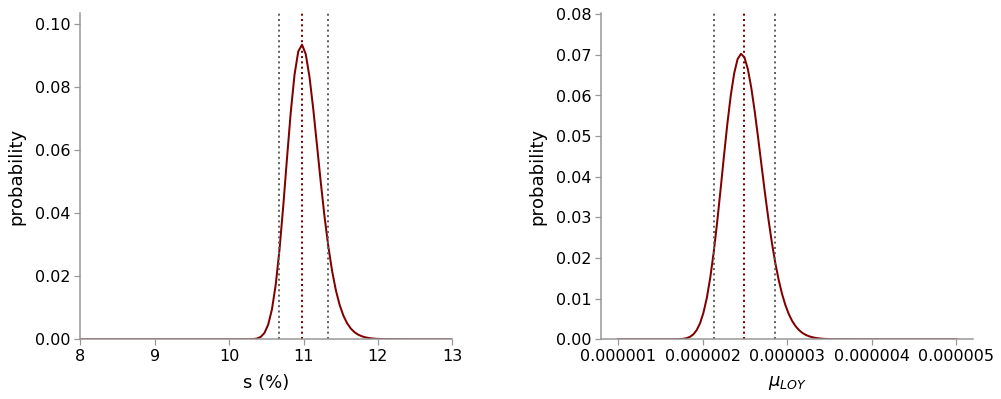

In [52]:
#Plot the distributions
plt.close('all')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(16, 6))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
gs.update(wspace=0.4)

s_list=np.linspace(0.08,0.13,100)
mut_list=np.linspace(10**-6, 5*10**-6, 100)

#MLE for increased mutation rate

squared_distance_s = np.array([[squared_distance_calculation_nonsyn_2D([mut, s], N_tau, VAF_info_LOY, list_of_ages, lmin_LOY, lmax_LOY, n_bins_LOY) for s in s_list] for mut in mut_list])
# print('squared_distance_s', squared_distance_s)

## S vs MUT
# Plot the density map using nearest-neighbor interpolation
logProbs_s = (-squared_distance_s)
max_x, max_y = np.unravel_index(np.argmax(logProbs_s), logProbs_s.shape)
z_max = logProbs_s[max_x, max_y]
z1_s = np.exp(logProbs_s-(z_max))
# print('z1_s', z1_s)


mg_s, mg_mut = np.meshgrid(s_list, mut_list)
ax1, min_s, max_s = confidence_interval_95_s(mg_s, mg_mut, z1_s, 'maroon')

squared_distance_mut = np.array([[squared_distance_calculation_nonsyn_2D([mut, s], N_tau, VAF_info_LOY, list_of_ages, lmin_LOY, lmax_LOY, n_bins_LOY) for mut in mut_list] for s in s_list])
# print('squared_distance_s', squared_distance_s)

logProbs_mut = (-squared_distance_mut)
max_x, max_y = np.unravel_index(np.argmax(logProbs_mut), logProbs_mut.shape)
z_max = logProbs_mut[max_x, max_y]
z1_mut = np.exp(logProbs_mut-(z_max))

mg_mut, mg_s = np.meshgrid(mut_list, s_list)
ax2, min_mut, max_mut = confidence_interval_95_mut(mg_mut, mg_s, z1_mut, 'maroon', '${\mu_{LOY}}$')

# plt.savefig('CI_interval_LOY.pdf', bbox_inches='tight')
plt.show()

### Plot main figure  

hist without zero is [11, 11, 4, 5, 11, 8, 8, 11, 9, 12, 4]
log_hist_for_plot is [-1.0971887  -1.0971887  -2.10878961 -1.88564606 -1.0971887  -1.41564243
 -1.41564243 -1.0971887  -1.2978594  -1.01017732 -2.10878961]
errors is [(0.3588363417595517, 0.3588363417595517, 0.693147180559945, 0.5927836007167084, 0.3588363417595517, 0.4362646682381306, 0.4362646682381306, 0.3588363417595517, 0.4054651081081646, 0.3406260401632655, 0.693147180559945), (0.2635261619552268, 0.2635261619552268, 0.4054651081081646, 0.3696400494024985, 0.2635261619552268, 0.3027332756136081, 0.3027332756136081, 0.2635261619552268, 0.287682072451781, 0.2536146631736357, 0.4054651081081646)]


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


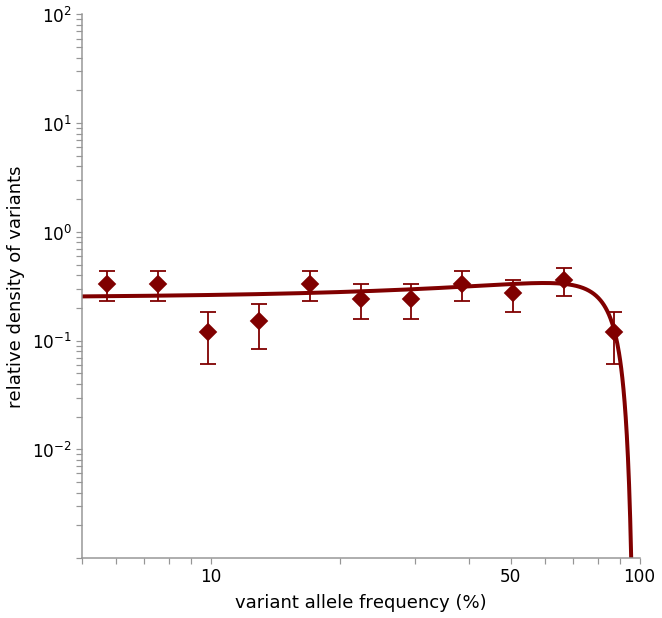

In [53]:
# Lists of colors for plots
plt.clf()
plt.close('all')
f, ax1 = plt.subplots(1, 1, figsize=(10,10))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)
f.subplots_adjust(hspace=0.4)

#linear binning : same bins and limits in the same simulation with same alpha

n_bins_LOY=11

lmin_LOY= np.log(trimmed_fmin)
lmax_LOY=np.log(trimmed_fmax)

log_LOY=np.linspace(np.log(trimmed_fmin), np.log(trimmed_fmax), 1000)
plot_log_hist_data_for_plot_not_rescaled(list_of_LOY, n_sample, \
                                                n_bins_LOY, lmin_LOY, lmax_LOY, '', 'D', 12, 'maroon')


# # logged in y axis
# density_drift_log=[]
# for l in log_LOY:
#     density_drift_contributed_by_diff_ages=0
#     for j in range(9):
#         t=93
#         density_drift_contributed_by_diff_ages=density_drift_contributed_by_diff_ages+(Predicted_LOY_drift_with_cutoff(l, N_tau, u_LOY, t)/9)
# #         print('t is',t)
#     density_drift_log.append(np.log(density_drift_contributed_by_diff_ages))
# ax1.plot(log_LOY, density_drift_log, zorder=2, color='black', lw=4, label='neutral drift theory')


# logged in y axis
s = s_LOY_bestfit
u_LOY = u_LOY_bestfit
density_selected_log=[]
for l in log_LOY:
    density_selected_contributed_by_diff_ages=0
    for j in range(len(list_of_ages)):
        t = list_of_ages[j]
        density_selected_contributed_by_diff_ages=density_selected_contributed_by_diff_ages+\
        (Predicted_LOY_beneficial_with_cutoff(l, N_tau, u_LOY, t, s)/len(list_of_ages))

    density_selected_log.append(np.log(density_selected_contributed_by_diff_ages))
ax1.plot(log_LOY, density_selected_log, zorder = 2, color = 'maroon', lw = 4, label = 'positive selection theory: s = 10 %')


ax1.set_xlim(lmin_LOY, lmax_LOY)


# ax1.legend(bbox_to_anchor=(0.8, 1), frameon=0, fontsize = 18)
# plt.savefig('Y_loss_v3.pdf', bbox_inches='tight')